In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import tensorflow as tf
import keras 
print("tf version: ", tf.__version__)
print("keras version: ", keras.__version__)

tf version:  2.7.0
keras version:  2.7.0


In [2]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import LearningRateScheduler
from keras.models import load_model

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#base_dir = os.getcwd()
base_dir = "/content/drive/MyDrive/논문"

In [9]:
base_dir

'/content/drive/MyDrive/논문'

In [5]:
'''
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_morse_dir = os.path.join(train_dir, 'morse')
os.mkdir(train_morse_dir)

train_noise_dir = os.path.join(train_dir, 'noise')
os.mkdir(train_noise_dir)

test_morse_dir = os.path.join(test_dir, 'morse')
os.mkdir(test_morse_dir)

test_noise_dir = os.path.join(test_dir, 'noise')
os.mkdir(test_noise_dir)
'''

"\ntrain_dir = os.path.join(base_dir, 'train')\nos.mkdir(train_dir)\n\ntest_dir = os.path.join(base_dir, 'test')\nos.mkdir(test_dir)\n\ntrain_morse_dir = os.path.join(train_dir, 'morse')\nos.mkdir(train_morse_dir)\n\ntrain_noise_dir = os.path.join(train_dir, 'noise')\nos.mkdir(train_noise_dir)\n\ntest_morse_dir = os.path.join(test_dir, 'morse')\nos.mkdir(test_morse_dir)\n\ntest_noise_dir = os.path.join(test_dir, 'noise')\nos.mkdir(test_noise_dir)\n"

In [10]:
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_morse_dir = os.path.join(train_dir, 'morse')
train_noise_dir = os.path.join(train_dir, 'noise')
test_morse_dir = os.path.join(test_dir, 'morse')
test_noise_dir = os.path.join(test_dir, 'noise')
print('훈련용 이미지 전체 개수:', len(os.listdir(train_morse_dir)))

훈련용 이미지 전체 개수: 173


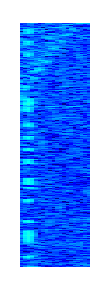

In [11]:
fname = os.listdir(train_morse_dir)[0]
img_path = os.path.join(train_morse_dir, fname)
img = image.load_img(img_path, target_size=(300, 100))
img

In [ ]:
# 모든 이미지를 1/255로 스케일 조정
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 변경
        target_size=(300, 100),
        batch_size=30,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블 필요
        # (다중분류시 class_mode='categorical'(원-핫 인코딩 레이블) 혹은 class_mode='sparse'(정수형 레이블))
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(300, 100),
        batch_size=20,
        class_mode='categorical')

Found 346 images belonging to 2 classes.


In [ ]:
##### Load the whole trained 1D CNN Model
model_dir = "./save_model"
model_path = os.path.join(model_dir, 'cnn_morse_1.h5')
conv_base = load_model(model_path)
conv_base.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 100, 8)       368       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 50, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 50, 16)       1936      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 25, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 25, 16)        3856      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 12, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 12, 32)       

In [ ]:
##### Load the only CNN structure except for classifier
layer_out = conv_base.get_layer('max_pooling2d_4')
CNN = models.Model(inputs=conv_base.input, outputs=layer_out.output)
CNN.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 300, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 100, 8)       368       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 50, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 50, 16)       1936      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 25, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 25, 16)        3856      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 12, 16)        0   

In [ ]:
### Pretrained 1D CNN structure
model = models.Sequential()
model.add(CNN)

model.add(layers.AveragePooling2D((1, 6)))
model.add(layers.Reshape((18,32)))

#model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.2)))
#model.add(layers.Bidirectional(layers.LSTM(32, dropout=0.1, recurrent_dropout=0.2)))

model.add(layers.LSTM(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.2))
model.add(layers.LSTM(32, dropout=0.1, recurrent_dropout=0.2))

#model.add(layers.Flatten()) # 구분기의 입력으로 연결하기 위하여 3D 텐서를 1D 텐서로 펼침
#model.add(layers.Dropout(0.3))
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(2, activation='softmax'))

model.add(layers.Dense(64, activation='elu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 18, 6, 32)         13872     
_________________________________________________________________
average_pooling2d_1 (Average (None, 18, 1, 32)         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 18, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 18, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

In [ ]:
# learning rate 구간별로 설정 0.1 ~ 0.001
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 120: # # Second step-decay
        lr *= 1e-2
    elif epoch > 80: # First step-decay
        lr *= 1e-1
    print('Learning rate : ', lr)
    
    return lr 

# callback 설정 - step-decay learning rate schedule
callback_list = [LearningRateScheduler(lr_schedule)]

In [ ]:
#optimizer=optimizers.RMSprop(lr=1e-3),
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['acc'])

In [ ]:
startTime = time.time()

# 제너레이터 사용시 fit_generator 메서드 사용
history = model.fit_generator(
      train_generator, #입력과 레이블의 배치를 끝없이 생성
      epochs=130,
      callbacks=callback_list,
      validation_data=validation_generator) #배치가 20개로 설정, 전체 검증 데이터 1,000개를 사용하려면, 50개의 배치 추출 필요
print("Computation time:{0:.3f} min.".format((time.time() - startTime)/60))

Epoch 1/130
Learning rate :  0.001
12/12 [==============================] - 3s 215ms/step - loss: 0.6975 - acc: 0.5116 - val_loss: 0.6645 - val_acc: 0.6125
Epoch 2/130
Learning rate :  0.001
12/12 [==============================] - 1s 89ms/step - loss: 0.6372 - acc: 0.6127 - val_loss: 0.6043 - val_acc: 0.6000
Epoch 3/130
Learning rate :  0.001
12/12 [==============================] - 1s 106ms/step - loss: 0.5907 - acc: 0.6908 - val_loss: 0.6167 - val_acc: 0.6250
Epoch 4/130
Learning rate :  0.001
12/12 [==============================] - 1s 101ms/step - loss: 0.5167 - acc: 0.6965 - val_loss: 0.5095 - val_acc: 0.7375
Epoch 5/130
Learning rate :  0.001
12/12 [==============================] - 1s 106ms/step - loss: 0.4836 - acc: 0.7861 - val_loss: 0.3579 - val_acc: 0.8000
Epoch 6/130
Learning rate :  0.001
12/12 [==============================] - 1s 104ms/step - loss: 0.4133 - acc: 0.8410 - val_loss: 0.2069 - val_acc: 0.8000
Epoch 7/130
Learning rate :  0.001
12/12 [=======================

12/12 [==============================] - 1s 108ms/step - loss: 0.0623 - acc: 0.9769 - val_loss: 0.2609 - val_acc: 0.9250
Epoch 54/130
Learning rate :  0.001
12/12 [==============================] - 1s 99ms/step - loss: 0.1221 - acc: 0.9538 - val_loss: 0.4238 - val_acc: 0.9000
Epoch 55/130
Learning rate :  0.001
12/12 [==============================] - 1s 106ms/step - loss: 0.1767 - acc: 0.9335 - val_loss: 0.1350 - val_acc: 0.8875
Epoch 56/130
Learning rate :  0.001
12/12 [==============================] - 1s 106ms/step - loss: 0.0739 - acc: 0.9884 - val_loss: 0.0544 - val_acc: 0.9500
Epoch 57/130
Learning rate :  0.001
12/12 [==============================] - 1s 102ms/step - loss: 0.0511 - acc: 0.9855 - val_loss: 0.1027 - val_acc: 0.9375
Epoch 58/130
Learning rate :  0.001
12/12 [==============================] - 1s 105ms/step - loss: 0.0613 - acc: 0.9798 - val_loss: 0.0201 - val_acc: 0.9500
Epoch 59/130
Learning rate :  0.001
12/12 [==============================] - ETA: 0s - loss: 0.

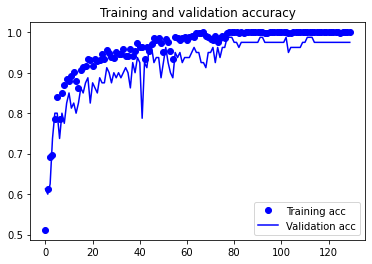

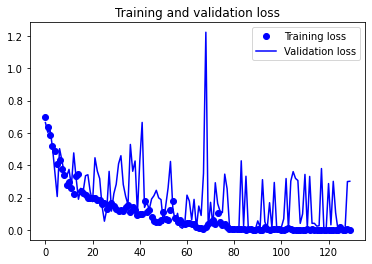

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
##### Obtain test result in terms of classification accuracy
scores = model.evaluate_generator(validation_generator, steps=4)
scores

[0.30108314752578735, 0.9750000238418579]